This simple notebook demonstrates how users can interleave text, code, and results in a single document. We start with a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values. The Jupyter notebook allows us to express that mathematically, using the typesetting language $\LaTeX{}$: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

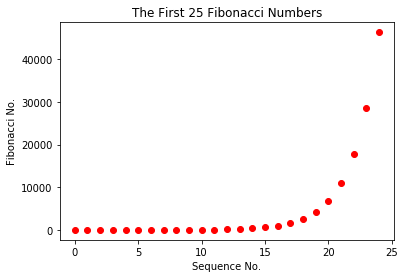

In [4]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
## uncomment the following call to ax.plot() (by removing the leading '#') and select 
## 'Cell > Run All' (in Binder) or 'Run > Run All Cells' (Jupyter) to change the graph below
# ax.plot (range(25), ar)
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

Anything you can do programmatically, can be documented in a notebook. Here we'll do some simple sequence analysis with Biopython. The following example is adapted from the [Biopython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). 

First, we'll read in a Genbank-formatted file, which represents a circular DNA, called a plasmid, from the bacterium, *Yersinia pestis*.

In [5]:
from Bio import SeqIO
from Bio.Seq import Seq

record = SeqIO.read("NC_005816.gb", "genbank")
record.seq

Seq('TGTAACGAACGGTGCAATAGTGATCCACACCCAACGCCTGAAATCAGATCCAGG...CTG', IUPACAmbiguousDNA())

How long is the DNA, and how many genes does it encode?

In [6]:
print("Length:", len(record.seq), "bp\n")

nGenes = 0
for feat in record.features:
    if (feat.type == "CDS"):
        nGenes +=1
        print (nGenes, feat.qualifiers['product'][0])

Length: 9609 bp

1 putative transposase
2 transposase/IS protein
3 putative replication regulatory protein
4 hypothetical protein
5 pesticin immunity protein
6 pesticin
7 hypothetical protein
8 outer membrane protease
9 putative transcriptional regulator
10 hypothetical protein


There are 10 genes. Let's focus on gene #5, which encodes the *Y. pestis* 'pesticin immunity protein' (*pim*). 

In [7]:
# adapted from https://www.biostars.org/p/249500/
for feat in record.features:
    if feat.type == "CDS":
        product = feat.qualifiers['product'][0]
        if product == 'pesticin immunity protein' :
            print ("pim gene location\nStart:", feat.location.start, "\nEnd:", feat.location.end)
            print ("GeneID:", feat.qualifiers.get("db_xref"))

pim gene location
Start: 4342 
End: 4780
GeneID: ['GI:45478716', 'GeneID:2767712']


These data show us that the *pim* gene is located between bases 4342 and 4780. Let's retrieve that segment ...

In [8]:
pim = record[4342:4780]

... and translate it.

In [9]:
print (pim.seq.translate())

MGGGMISKLFCLALIFLSSSGLAEKNTYTAKDILQNLELNTFGNSLSHGIYGKQTTFKQTEFTNIKSNTKKHIALINKDNSWMISLKILGIKRDEYTVCFEDFSLIRPPTYVAIHPLLIKKVKSGNFIVVKEIKKSIPGCTVYYH*


Now, let's find out more about this gene, using the NCBI Entrez database. We learned the accession number above: `GeneID: ['GI:45478716', 'GeneID:2767712']`.

In [10]:
from Bio import Entrez

In [11]:
Entrez.email = "A.N.Other@example.com"  # Always tell NCBI who you are
handle = Entrez.efetch (db="nucleotide",id="45478716",rettype="gb",retmode="text")
print (handle.read())

LOCUS       NP_995571                145 aa            linear   CON 16-DEC-2014
DEFINITION  pesticin immunity protein (plasmid) [Yersinia pestis biovar
            Microtus str. 91001].
ACCESSION   NP_995571
VERSION     NP_995571.1
DBLINK      BioProject: PRJNA58037
DBSOURCE    REFSEQ: accession NC_005816.1
KEYWORDS    RefSeq.
SOURCE      Yersinia pestis biovar Microtus str. 91001
  ORGANISM  Yersinia pestis biovar Microtus str. 91001
            Bacteria; Proteobacteria; Gammaproteobacteria; Enterobacteriales;
            Enterobacteriaceae; Yersinia.
REFERENCE   1  (residues 1 to 145)
  AUTHORS   Zhou,D., Tong,Z., Song,Y., Han,Y., Pei,D., Pang,X., Zhai,J., Li,M.,
            Cui,B., Qi,Z., Jin,L., Dai,R., Du,Z., Wang,J., Guo,Z., Wang,J.,
            Huang,P. and Yang,R.
  TITLE     Genetics of metabolic variations between Yersinia pestis biovars
            and the proposal of a new biovar, microtus
  JOURNAL   J. Bacteriol. 186 (15), 5147-5152 (2004)
   PUBMED   15262951
REFERENCE  

The Entrez record contains a wealth of info to get us started on *pim*, including references and additional database accession numbers. 

Jupyter also supports interactive data exploration. Here we'll add an interactive map, just as in our June [mapping feature](https://www.nature.com/articles/d41586-018-05331-6) -- something you might do when working with geospatial data. This requires the Python Leaflet library, folium. (**Uncomment the following cell (by deleting the leading `#`) if you don't have folium installed.**)

In [12]:
# !pip install folium

In [13]:
import folium

Now we create a simple map: a few points in London, Oxford and Cambridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). 

In [14]:
import pandas as pd

# create a data frame of locations
name = ["Nature", "Francis Crick Institute", "University College London", 
        "MRC Laboratory for Molecular Cell Biology", "Kings College London",
       "Imperial College London", "Cambridge University", "Oxford University",
       "Platform 9-3/4"]
lat = [51.533925,51.531877,51.524486,51.524435,51.511573,51.498780,52.206960,51.754843,51.532349]
long = [-0.121553,-0.128767,-0.133997,-0.132495,-0.116083,-0.174888,0.115034,-1.254302,-0.123806]

df = pd.DataFrame({'Name': name, 'Lat': lat, 'Long': long})

In [15]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for index,row in df.iterrows():
    folium.CircleMarker(
    location=[row['Lat'], row['Long']],
    popup=row['Name'],
    color=('crimson' if row['Name'] == 'Nature' else 'blue'),
    fill=False,
    ).add_to(m)

folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map. **Note that this map is interactive**: you can zoom, pan, click the points of interest, and alternate between the two layers (by clicking on the tiles icon in the upper-right corner of the map).

In [16]:
m

Document our session, for [computational reproducibility](https://www.nature.com/articles/d41586-018-05990-5)!

In [17]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.7.0-x86_64-i386-64bit',
 'sys_executable': '/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.3 | packaged by conda-forge | (default, Oct  5 2017, '
                '19:18:17) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'}


In [18]:
!pip freeze | grep -E 'folium|matplotlib|pandas|biopython'

biopython==1.70
folium==0.6.0
matplotlib==2.1.0
pandas==0.20.3
